In [1]:
import numpy as np
import matplotlib.pylab as plt
from lsst.sims.coordUtils import _chipNameFromRaDec
from lsst.obs.lsst import LsstCamMapper
import lsst.sims.utils as simsUtils


In [2]:
# Need to put these in sims_utils and remove from MAF and scheduler.

def gnomonic_project_toxy(RA1, Dec1, RAcen, Deccen):
    """Calculate x/y projection of RA1/Dec1 in system with center at RAcen, Deccen.
    Input radians. Grabbed from sims_selfcal"""
    # also used in Global Telescope Network website
    cosc = np.sin(Deccen) * np.sin(Dec1) + np.cos(Deccen) * np.cos(Dec1) * np.cos(RA1-RAcen)
    x = np.cos(Dec1) * np.sin(RA1-RAcen) / cosc
    y = (np.cos(Deccen)*np.sin(Dec1) - np.sin(Deccen)*np.cos(Dec1)*np.cos(RA1-RAcen)) / cosc
    return x, y


def gnomonic_project_tosky(x, y, RAcen, Deccen):
    """Calculate RA/Dec on sky of object with x/y and RA/Cen of field of view.
    Returns Ra/Dec in radians."""
    denom = np.cos(Deccen) - y * np.sin(Deccen)
    RA = RAcen + np.arctan2(x, denom)
    Dec = np.arctan2(np.sin(Deccen) + y * np.cos(Deccen), np.sqrt(x*x + denom*denom))
    return RA, Dec


In [3]:
mapper = LsstCamMapper()
camera = mapper.camera
epoch = 2000.0

ra = 0.
dec = 0.
rotSkyPos = 0.
mjd = 5300.

obs_metadata = simsUtils.ObservationMetaData(pointingRA=np.degrees(ra),
                                                             pointingDec=np.degrees(dec),
                                                             rotSkyPos=np.degrees(rotSkyPos),
                                                             mjd=mjd)

/Users/yoachim/lsst/stack/miniconda3-py38_4.9.2-0.4.1/DarwinX86/obs_lsst/21.0.0-17-g4778fb9+9a7018fc91/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():


In [4]:
nside = int(500)
# 60k pixels, from 0 to 3.5 degrees
x_one = np.linspace(-1.75, 1.75, int(nside))


In [5]:
# make 2-d x,y arrays
x_two = np.broadcast_to(x_one, (nside, nside))
y_two = np.broadcast_to(x_one, (nside, nside)).T

result = np.ones((nside,nside), dtype=bool)

In [6]:
ra_two, dec_two = gnomonic_project_tosky(np.radians(x_two), np.radians(y_two), ra, dec)

In [7]:
chipNames = _chipNameFromRaDec(ra_two.ravel(),dec_two.ravel(),epoch=epoch,
                               camera=camera, obs_metadata=obs_metadata)


In [8]:
chipNames =  chipNames.reshape(nside,nside)
result[np.where(chipNames == None)] = False

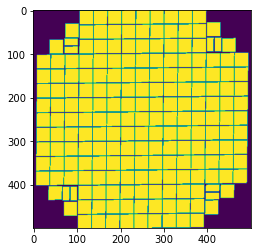

In [9]:
plt.imshow(result)

In [10]:
# so, we now have an array that says if a spot is on silicon or not. 

# The future procedure, take the slicePoint, gnomic project to x,y for each overlapping pointing. 
# rotate by (negative?) the rotSkyPos value (about 0,0). 
# Then convert x,y (in radians) to index based on the pixelscale we created the map in 
# Then it's just an index lookup of result[x_indx,y_indx] 
# dataSlice = dataSlice[fovmap[x_indx,y_indx]]]